In [1]:
!pip install mediapipe
!pip install mtcnn
!pip install keras-FaceNet


DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/face_recognition-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/face_recognition-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/face_recognition-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import mediapipe
#importing the pickle file

import pickle
with open('mini2.pkl', 'rb') as f:
    model = pickle.load(f)
try:
    classes = model.classes_
    print("Model was trained on the following classes:", classes)
except AttributeError:
    print("Model does not have a 'classes_' attribute.")

Model was trained on the following classes: ['Bharat' 'Bharat Sir' 'Bhargav' 'Bhavya' 'Bindhu Madam' 'Chaitanya'
 'Chaitanya Kodali' 'Dinesh' 'Hari' 'Harini' 'Karthik' 'Kokila' 'Narsimha'
 'Prasad Chinta' 'Pravallika' 'Raghav' 'Revanth' 'Rohit' 'Sailaja Mam'
 'Sajid Khan Patan' 'Sasaank Bezawada' 'Shirin' 'Sobhana Madam' 'Sowmya'
 'Srija' 'Vikas']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import csv
import copy
import argparse
import itertools
from collections import Counter
from collections import deque

import cv2 as cv
import numpy as np
import mediapipe as mp

from utils import CvFpsCalc
from model import KeyPointClassifier
from model import PointHistoryClassifier

In [4]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'


from keras_facenet import FaceNet
from mtcnn.mtcnn import MTCNN
detector=MTCNN()
embedder=FaceNet()

In [5]:
import argparse

def get_args():
    parser = argparse.ArgumentParser()

    parser.add_argument("--device", type=int, default=0)
    parser.add_argument("--width", help='cap width', type=int, default=960)
    parser.add_argument("--height", help='cap height', type=int, default=540)

    parser.add_argument('--use_static_image_mode', action='store_true')
    parser.add_argument("--min_detection_confidence",
                        help='min_detection_confidence',
                        type=float,
                        default=0.7)
    parser.add_argument("--min_tracking_confidence",
                        help='min_tracking_confidence',
                        type=float,  # Fixed: Changed from int to float
                        default=0.5)

    args, _ = parser.parse_known_args()  # Fixed: Avoids crashing due to unrecognized args

    return args


In [6]:
def select_mode(key, mode):
    number = -1
    if 48 <= key <= 57:  # 0 ~ 9
        number = key - 48
    if key == 110:  # n
        mode = 0
    if key == 107:  # k
        mode = 1
    if key == 104:  # h
        mode = 2
    return number, mode

In [7]:
def calc_bounding_rect(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = np.empty((0, 2), int)

    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point = [np.array((landmark_x, landmark_y))]

        landmark_array = np.append(landmark_array, landmark_point, axis=0)

    x, y, w, h = cv.boundingRect(landmark_array)

    return [x, y, x + w, y + h]

In [8]:
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

In [9]:
def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list

In [10]:
def pre_process_landmark(landmark_list):
    temp_landmark_list = [[lm[0], lm[1]] for lm in landmark_list]  # Convert tuples to lists

    base_x, base_y = temp_landmark_list[0][0], temp_landmark_list[0][1]

    for index in range(len(temp_landmark_list)):
        temp_landmark_list[index] = [
            temp_landmark_list[index][0] - base_x,
            temp_landmark_list[index][1] - base_y
        ]

    # Convert to a one-dimensional list
    flatten_landmark_list = [coord for point in temp_landmark_list for coord in point]
    return flatten_landmark_list


In [11]:
def logging_csv(number, mode, landmark_list, point_history_list):
    if mode == 0:
        pass
    if mode == 1 and (0 <= number <= 9):
        csv_path = 'model/keypoint_classifier/keypoint.csv'
        with open(csv_path, 'a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow([number, *landmark_list])
    if mode == 2 and (0 <= number <= 9):
        csv_path = 'model/point_history_classifier/point_history.csv'
        with open(csv_path, 'a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow([number, *point_history_list])
    return

In [12]:
def draw_landmarks(image, landmark_point):
    if len(landmark_point) > 0:
        # Thumb
        cv.line(image, tuple(landmark_point[2]), tuple(landmark_point[3]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[2]), tuple(landmark_point[3]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[3]), tuple(landmark_point[4]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[3]), tuple(landmark_point[4]),
                (255, 255, 255), 2)

        # Index finger
        cv.line(image, tuple(landmark_point[5]), tuple(landmark_point[6]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[5]), tuple(landmark_point[6]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[6]), tuple(landmark_point[7]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[6]), tuple(landmark_point[7]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[7]), tuple(landmark_point[8]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[7]), tuple(landmark_point[8]),
                (255, 255, 255), 2)

        # Middle finger
        cv.line(image, tuple(landmark_point[9]), tuple(landmark_point[10]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[9]), tuple(landmark_point[10]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[10]), tuple(landmark_point[11]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[10]), tuple(landmark_point[11]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[11]), tuple(landmark_point[12]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[11]), tuple(landmark_point[12]),
                (255, 255, 255), 2)

        # Ring finger
        cv.line(image, tuple(landmark_point[13]), tuple(landmark_point[14]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[13]), tuple(landmark_point[14]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[14]), tuple(landmark_point[15]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[14]), tuple(landmark_point[15]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[15]), tuple(landmark_point[16]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[15]), tuple(landmark_point[16]),
                (255, 255, 255), 2)

        # Little finger
        cv.line(image, tuple(landmark_point[17]), tuple(landmark_point[18]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[17]), tuple(landmark_point[18]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[18]), tuple(landmark_point[19]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[18]), tuple(landmark_point[19]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[19]), tuple(landmark_point[20]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[19]), tuple(landmark_point[20]),
                (255, 255, 255), 2)

        # Palm
        cv.line(image, tuple(landmark_point[0]), tuple(landmark_point[1]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[0]), tuple(landmark_point[1]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[1]), tuple(landmark_point[2]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[1]), tuple(landmark_point[2]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[2]), tuple(landmark_point[5]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[2]), tuple(landmark_point[5]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[5]), tuple(landmark_point[9]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[5]), tuple(landmark_point[9]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[9]), tuple(landmark_point[13]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[9]), tuple(landmark_point[13]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[13]), tuple(landmark_point[17]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[13]), tuple(landmark_point[17]),
                (255, 255, 255), 2)
        cv.line(image, tuple(landmark_point[17]), tuple(landmark_point[0]),
                (0, 0, 0), 6)
        cv.line(image, tuple(landmark_point[17]), tuple(landmark_point[0]),
                (255, 255, 255), 2)

    # Key Points
    for index, landmark in enumerate(landmark_point):
        if index == 0:  # 手首1
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 1:  # 手首2
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 2:  # 親指：付け根
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 3:  # 親指：第1関節
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 4:  # 親指：指先
            cv.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 5:  # 人差指：付け根
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 6:  # 人差指：第2関節
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 7:  # 人差指：第1関節
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 8:  # 人差指：指先
            cv.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 9:  # 中指：付け根
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 10:  # 中指：第2関節
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 11:  # 中指：第1関節
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 12:  # 中指：指先
            cv.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 13:  # 薬指：付け根
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 14:  # 薬指：第2関節
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 15:  # 薬指：第1関節
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 16:  # 薬指：指先
            cv.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 17:  # 小指：付け根
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 18:  # 小指：第2関節
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 19:  # 小指：第1関節
            cv.circle(image, (landmark[0], landmark[1]), 5, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 20:  # 小指：指先
            cv.circle(image, (landmark[0], landmark[1]), 8, (255, 255, 255),
                      -1)
            cv.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)

    return image

In [13]:
def draw_bounding_rect(use_brect, image, brect):
    if use_brect:
        # Outer rectangle
        cv.rectangle(image, (brect[0], brect[1]), (brect[2], brect[3]),
                     (0, 0, 0), 1)

    return image

In [14]:
def draw_info_text(image, brect, handedness, hand_sign_text,
                   finger_gesture_text):
    cv.rectangle(image, (brect[0], brect[1]), (brect[2], brect[1] - 22),
                 (0, 0, 0), -1)

    info_text = handedness.classification[0].label[0:]
    if hand_sign_text != "":
        info_text = info_text + ':' + hand_sign_text
    cv.putText(image, info_text, (brect[0] + 5, brect[1] - 4),
               cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv.LINE_AA)

    if finger_gesture_text != "":
        cv.putText(image, "Finger Gesture:" + finger_gesture_text, (10, 60),
                   cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 4, cv.LINE_AA)
        cv.putText(image, "Finger Gesture:" + finger_gesture_text, (10, 60),
                   cv.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2,
                   cv.LINE_AA)

    return image

In [15]:
def draw_point_history(image, point_history):
    for index, point in enumerate(point_history):
        if point[0] != 0 and point[1] != 0:
            cv.circle(image, (point[0], point[1]), 1 + int(index / 2),
                      (152, 251, 152), 2)

    return image

In [16]:
def draw_info(image, fps, mode, number):
    cv.putText(image, "FPS:" + str(fps), (10, 30), cv.FONT_HERSHEY_SIMPLEX,
               1.0, (0, 0, 0), 4, cv.LINE_AA)
    cv.putText(image, "FPS:" + str(fps), (10, 30), cv.FONT_HERSHEY_SIMPLEX,
               1.0, (255, 255, 255), 2, cv.LINE_AA)

    mode_string = ['Logging Key Point', 'Logging Point History']
    if 1 <= mode <= 2:
        cv.putText(image, "MODE:" + mode_string[mode - 1], (10, 90),
                   cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1,
                   cv.LINE_AA)
        if 0 <= number <= 9:
            cv.putText(image, "NUM:" + str(number), (10, 110),
                       cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1,
                       cv.LINE_AA)
    return image

In [17]:
import cv2 as cv
import time
import copy
import csv
from collections import Counter, deque
import mediapipe as mp

# Assuming these classes and functions are already defined
# KeyPointClassifier, PointHistoryClassifier, get_args, select_mode, calc_bounding_rect,
# calc_landmark_list, pre_process_landmark, pre_process_point_history, logging_csv,
# draw_bounding_rect, draw_landmarks, draw_info_text, draw_point_history, draw_info


def recognize_hand_gesture():
    args = get_args()
    cap_device = args.device
    cap_width = args.width
    cap_height = args.height
    use_static_image_mode = args.use_static_image_mode
    min_detection_confidence = args.min_detection_confidence
    min_tracking_confidence = args.min_tracking_confidence
    use_brect = True

    cap = cv.VideoCapture(cap_device)
    cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
    cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)

    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(
        static_image_mode=use_static_image_mode,
        max_num_hands=1,
        min_detection_confidence=min_detection_confidence,
        min_tracking_confidence=min_tracking_confidence,
    )

    keypoint_classifier = KeyPointClassifier()
    point_history_classifier = PointHistoryClassifier()

    with open('model/keypoint_classifier/keypoint_classifier_label.csv', encoding='utf-8-sig') as f:
        keypoint_classifier_labels = [row[0] for row in csv.reader(f)]

    start_time = time.time()
    recognized_gestures = []

    while time.time() - start_time < 5:  # Capture for 5 seconds
        ret, image = cap.read()
        if not ret:
            print("Failed to capture image. Exiting...")
            break

        image = cv.flip(image, 1)
        debug_image = copy.deepcopy(image)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = hands.process(image)
        image.flags.writeable = True

        if results.multi_hand_landmarks is not None:
            for hand_landmarks in results.multi_hand_landmarks:
                landmark_list = calc_landmark_list(debug_image, hand_landmarks)
                pre_processed_landmark_list = pre_process_landmark(landmark_list)
                hand_sign_id = keypoint_classifier(pre_processed_landmark_list)
                recognized_gestures.append(keypoint_classifier_labels[hand_sign_id])

        cv.imshow('Hand Gesture Recognition', debug_image)
        if cv.waitKey(10) & 0xFF == 27:
            break

    cap.release()
    cv.destroyAllWindows()

    if recognized_gestures:
        most_common_gesture = Counter(recognized_gestures).most_common(1)[0][0]
        return most_common_gesture
    else:
        return "No gesture recognized"
#recognize_hand_gesture()

In [18]:
# For webcam input

import cv2
import numpy as np
from mtcnn import MTCNN

# Initialize the MTCNN detector
detector = MTCNN()
threshold = 0.6
def predict_name(face_embedding, threshold):
    probabilities = model.predict_proba(face_embedding)[0]
    predicted_index = np.argmax(probabilities)
    if probabilities[predicted_index] >= threshold:
        predicted_name = model.classes_[predicted_index]
    else:
        predicted_name = "UNKNOWN"
    return predicted_name, "{:.2f}".format(probabilities[predicted_index])

# Function to get the embedding of a face image
def get_embedding(face_img):
    face_img = face_img.astype('float32')
    face_img = cv2.resize(face_img, (160, 160))  # Resize face image to match model input size
    face_img = np.expand_dims(face_img, axis=0)
    yhat = embedder.embeddings(face_img)
    return yhat[0]
# Function to recognize faces
def recognize_faces(frame):
    result = detector.detect_faces(frame)
    best_match = None
    max_ratio = 0.0  # Ensure it's a float

    if result:
        for face in result:
            bounding_box = face['box']
            keypoints = face['keypoints']
            face_img = frame[bounding_box[1]:bounding_box[1] + bounding_box[3], bounding_box[0]:bounding_box[0] + bounding_box[2]]
            face_embedding = get_embedding(face_img)
            face_embedding = [face_embedding]
            
            name, ratio = predict_name(face_embedding, threshold)
            cv2.imshow('Face Detection', frame)
            try:
                ratio = float(ratio)  # Convert ratio to float
            except ValueError:
                continue  # Skip if conversion fails

            if ratio > max_ratio:  # Compare numerical values
                max_ratio = ratio
                best_match = name

    return best_match  # Return the name with the highest ratio
  # Return the name with the highest ratio

            #return name
            #if name == "UNKNOWN":
            #    cv2.rectangle(frame, (bounding_box[0], bounding_box[1]), (bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]), (255, 0, 0), 2)
            #    cv2.putText(frame, f"{name}{ratio}", (bounding_box[0], bounding_box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            #else:
            #    cv2.rectangle(frame, (bounding_box[0], bounding_box[1]), (bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]), (0, 255, 0), 2)
            #    cv2.putText(frame, f"{name}{ratio}", (bounding_box[0], bounding_box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            #cv2.circle(frame, (keypoints['left_eye']), 2, (0, 0, 255), 2)
            #cv2.circle(frame, (keypoints['right_eye']), 2, (0, 0, 255), 2)
            #cv2.circle(frame, (keypoints['nose']), 2, (0, 0, 255), 2)
            #cv2.circle(frame, (keypoints['mouth_left']), 2, (0, 0, 255), 2)
            #cv2.circle(frame, (keypoints['mouth_right']), 2, (0, 0, 255), 2)
#cap = cv2.VideoCapture(0)
#while True:
#    try:
#        # Capture frame from the IP camera
#        ret, frame = cap.read()
#
#        if not ret:
#            print("Error: Failed to capture frame from the IP camera.")
#            break
#
#        # Run MTCNN detection and face recognition on the frame
#        #recognize_faces(frame)
#
#        # Display the resulting frame
#        cv2.imshow('Face Detection', frame)
#
#        # Press 'q' to exit the loop
#        if cv2.waitKey(1) & 0xFF == ord('q'):
#            break
#    except Exception as e:
#        print("Error:", e)
#
## Release the capture object and close all windows
#cap.release()
#cv2.destroyAllWindows()


In [19]:
#### Single Threaded
#### First camera gets on for Face recognition, the name will be detected, 
#### then again the camera gets on for the hand gesture recognition
#### if both the names are same then "Authorised user" otherwise "Unauthorised user

#def capture_frames(duration=10):
#    cap = cv.VideoCapture(0)
#    start_time = time.time()
#    result = None
#    
#    while time.time() - start_time < duration:
#        ret, frame = cap.read()
#        if not ret:
#            continue
#        result = frame  # Store the latest frame
#    
#    cap.release()
#    return result
## Capture face recognition input
#face_frame = capture_frames()
#person_name = recognize_faces(face_frame)
#print("Recognized Person:", person_name)
#
## Capture hand gesture input
#gesture_label = recognize_hand_gesture()
#print("Recognized Gesture:", gesture_label)
#
## Compare results
#if person_name == gesture_label:
#    print("Authorized User")
#else:
#    print("Unauthorized User")

In [23]:

### Multithreaded environment 
### Both face recognition and hand gesture recognition takes place at once.


import cv2
import time
import copy
import csv
import threading
import numpy as np
from collections import Counter, deque
import mediapipe as mp
from mtcnn import MTCNN
import gradio as gr

# Initialize face detector
face_detector = MTCNN()
threshold = 0.6
embedder=FaceNet()
# Initialize hand detector
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Placeholder functions for face embedding and prediction
def get_embedding(face_img):
    face_img = cv2.resize(face_img, (160, 160))
    face_img = np.expand_dims(face_img, axis=0)
    return embedder.embeddings(face_img)[0]

def predict_name(face_embedding, threshold):
    probabilities = model.predict_proba(face_embedding)[0]
    predicted_index = np.argmax(probabilities)
    if probabilities[predicted_index] >= threshold:
        return model.classes_[predicted_index], "{:.2f}".format(probabilities[predicted_index])
    return "UNKNOWN", "{:.2f}".format(probabilities[predicted_index])

# FPS Calculation Class
class CvFpsCalc:
    def __init__(self, buffer_len=10):
        self.times = deque(maxlen=buffer_len)
    
    def get(self):
        self.times.append(time.time())
        if len(self.times) < 2:
            return 0.0
        return len(self.times) / (self.times[-1] - self.times[0])

fps_calculator = CvFpsCalc()

# Face Recognition Function
def recognize_faces(frame):
    result = face_detector.detect_faces(frame)
    if result:
        for face in result:
            bounding_box = face['box']
            face_img = frame[bounding_box[1]:bounding_box[1] + bounding_box[3], bounding_box[0]:bounding_box[0] + bounding_box[2]]
            face_embedding = [get_embedding(face_img)]
            name, ratio = predict_name(face_embedding, threshold)
            color = (0, 255, 0) if name != "UNKNOWN" else (255, 0, 0)
            cv2.rectangle(frame, (bounding_box[0], bounding_box[1]), (bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]), color, 2)
            cv2.putText(frame, f"{name}", (bounding_box[0], bounding_box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    return frame

# Hand Gesture Recognition Function
def recognize_hand_gesture(frame):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(image)
    gesture = "Unknown"
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            gesture = classify_gesture(hand_landmarks)  # Modify with actual gesture classification function
    return frame, gesture

# Actual hand gesture classification function
def classify_gesture(hand_landmarks):
    with open('model/keypoint_classifier/keypoint_classifier_label.csv', encoding='utf-8-sig') as f:
        keypoint_classifier_labels = [row[0] for row in csv.reader(f)]
    keypoint_classifier = KeyPointClassifier()
    landmark_list = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]
    pre_processed_landmark_list = pre_process_landmark(landmark_list)
    gesture_id = keypoint_classifier(pre_processed_landmark_list)
    return keypoint_classifier_labels[gesture_id] if gesture_id < len(keypoint_classifier_labels) else "Unknown"

# Threaded Function to Run Face and Hand Gesture Recognition Simultaneously
def process_frame():
    cap = cv2.VideoCapture(0)
    recognized_gesture = "Unknown"
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture image. Exiting...")
            break

        fps = fps_calculator.get()
        
        face_thread = threading.Thread(target=recognize_faces, args=(frame,))
        face_thread.start()
        face_thread.join()
        
        frame, recognized_gesture = recognize_hand_gesture(frame)
        
        cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame, f"Finger Gesture: {recognized_gesture}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
        cv2.imshow('Hand Gesture Recognition', frame)
        if cv2.waitKey(10) & 0xFF == 27:
            break
    
    cap.release()
    cv2.destroyAllWindows()

with gr.Blocks() as authenticate:
    # gr.Markdown("# 🎯 Things Detector - Advanced Data Science Edition")

    input_img = gr.Image(label="📷 Upload or Capture Image", type="numpy")

    detect_btn = gr.Button("🔍 Authenticate")
    output_img = gr.Image(label="Verification", type="numpy")
    detect_btn.click(fn=process_frame(), inputs=input_img,
                     outputs=[output_img])

authenticate.launch()
# Run the process
#process_frame() #this is the multi threaded code.So add the function to monitor the performance.

I0000 00:00:1745560876.980211 1013845 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3
W0000 00:00:1745560876.988556 1020584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745560876.992946 1020582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
2025-04-25 11:31:19.237 python[91594:1013845] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2025-04-25 11:31:28.737 python[91594:1013845] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-25 11:31:28.737 python[91594:1013845] +[IMKInputSession subclass]: chose IMKInputSession_Modern


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [ ]:
#pip install fastapi uvicorn


In [ ]:
#from fastapi import FastAPI, UploadFile, File
#import cv2
#import numpy as np
#import io
#
#app = FastAPI()
#@app.post("/process/")
#async def process_image(file: UploadFile = File(...)):
#    contents = await file.read()
#    np_array = np.frombuffer(contents, np.uint8)
#    frame = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
#    
#    processed_frame = process_frame(frame)
#    _, encoded_image = cv2.imencode(".jpg", processed_frame)
#    
#    return {"processed_image": encoded_image.tobytes()}
#

In [22]:
# single threaded environment performance test
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

# Initialize FPS tracking
fps_list = []
time_list = []

class FPSMonitor:
    def __init__(self):
        self.start_time = time.time()
        self.frame_count = 0

    def update(self):
        self.frame_count += 1
        now = time.time()
        elapsed = now - self.start_time
        fps = self.frame_count / elapsed if elapsed > 0 else 0
        return fps, elapsed

# Use your recognizer functions
# face_frame => use recognize_faces(frame) --> returns name
# gesture => recognize_hand_gesture() --> returns label

def capture_frames(duration=5, monitor_fps=False):
    cap = cv2.VideoCapture(0)
    start_time = time.time()
    fps_monitor = FPSMonitor()
    result = None

    while time.time() - start_time < duration:
        ret, frame = cap.read()
        if not ret:
            continue
        result = frame

        if monitor_fps:
            fps, elapsed = fps_monitor.update()
            fps_list.append(fps)
            time_list.append(elapsed)
            cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow('Capture', frame)
            if cv2.waitKey(1) & 0xFF == 27:
                break

    cap.release()
    cv2.destroyAllWindows()
    return result

# === Run Single-Threaded Flow with Monitoring ===
print("[INFO] Starting Face Recognition...")
face_frame = capture_frames(duration=5, monitor_fps=True)
person_name = recognize_faces(face_frame)
print("Recognized Person:", person_name)

print("[INFO] Starting Hand Gesture Recognition...")
gesture_label = recognize_hand_gesture()  # Assumes this uses its own camera feed
print("Recognized Gesture:", gesture_label)

# Final decision
if person_name == gesture_label:
    print("\n✅ Authorized User")
else:
    print("\n❌ Unauthorized User")

# Save FPS data for graphing
np.save('fps_single.npy', fps_list)
np.save('time_single.npy', time_list)

print(f"[INFO] FPS data saved. Total frames: {len(fps_list)}")


[INFO] Starting Face Recognition...
Recognized Person: [[[104 133 146]
  [ 99 128 140]
  [ 93 122 133]
  ...
  [238 227 212]
  [237 227 212]
  [237 227 212]]

 [[108 137 148]
  [103 133 143]
  [ 92 123 134]
  ...
  [238 227 212]
  [237 227 212]
  [240 229 214]]

 [[112 142 153]
  [109 138 149]
  [ 97 127 138]
  ...
  [237 225 210]
  [238 226 211]
  [243 230 216]]

 ...

 [[114 105  63]
  [110 101  66]
  [112 104  77]
  ...
  [146 170 184]
  [145 169 183]
  [142 166 180]]

 [[ 94  84  48]
  [ 98  89  61]
  [111 104  84]
  ...
  [145 169 183]
  [143 168 181]
  [142 166 180]]

 [[ 88  79  48]
  [ 96  88  65]
  [114 109  93]
  ...
  [145 169 183]
  [143 168 181]
  [142 166 180]]]
[INFO] Starting Hand Gesture Recognition...


TypeError: recognize_hand_gesture() missing 1 required positional argument: 'frame'

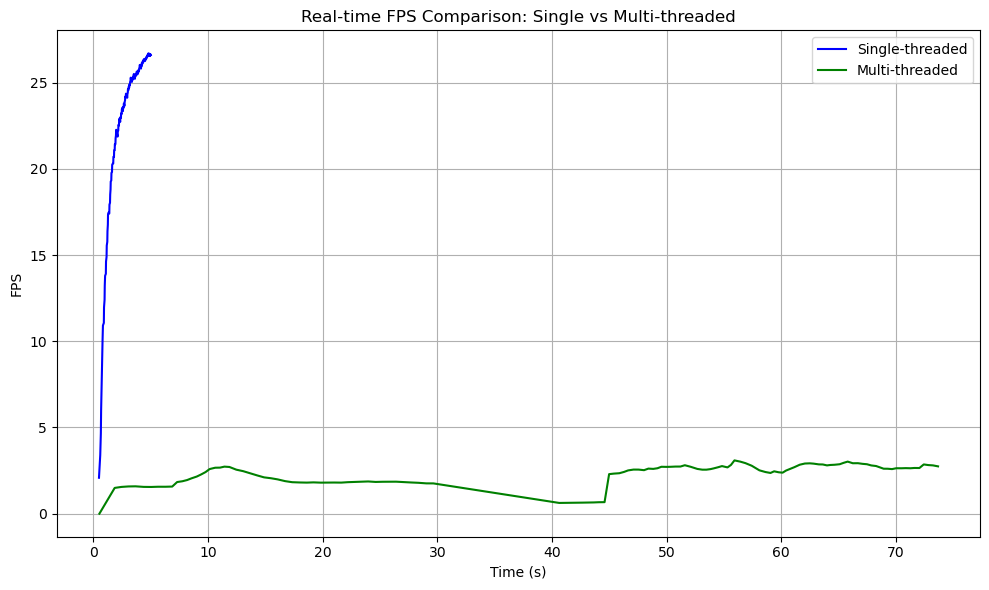

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Load saved data
fps_single = np.load('./fps_single.npy')
time_single = np.load('./time_single.npy')
fps_multi = np.load('./fps_multi.npy')
time_multi = np.load('./time_multi.npy')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_single, fps_single, label='Single-threaded', color='blue')
plt.plot(time_multi, fps_multi, label='Multi-threaded', color='green')
plt.xlabel('Time (s)')
plt.ylabel('FPS')
plt.title('Real-time FPS Comparison: Single vs Multi-threaded')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("fps_comparison.png", dpi=300)  # for inserting in paper
plt.show()


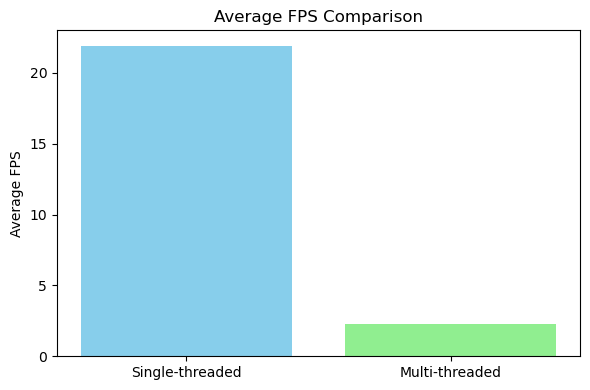

In [24]:
avg_single = np.mean(fps_single)
avg_multi = np.mean(fps_multi)

plt.figure(figsize=(6, 4))
plt.bar(['Single-threaded', 'Multi-threaded'], [avg_single, avg_multi], color=['skyblue', 'lightgreen'])
plt.ylabel('Average FPS')
plt.title('Average FPS Comparison')
plt.tight_layout()
plt.savefig("avg_fps_bar.png", dpi=300)
plt.show()


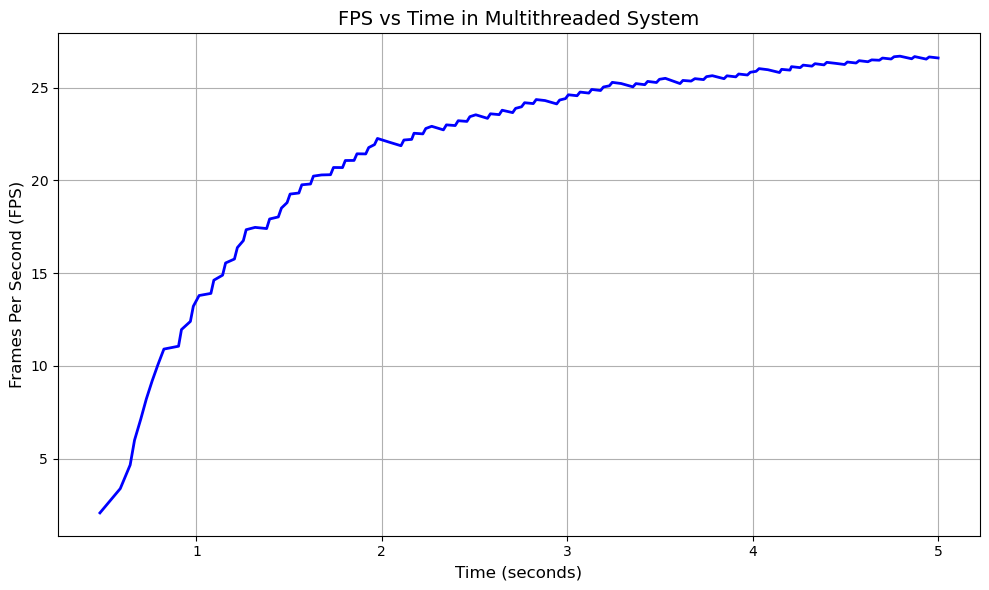

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Load saved FPS and Time data
fps = np.load('fps_single.npy')
time_elapsed = np.load('time_single.npy')

# Plotting FPS vs Time
plt.figure(figsize=(10, 6))
plt.plot(time_elapsed, fps, color='blue', linewidth=2)
plt.title('FPS vs Time in Multithreaded System', fontsize=14)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Frames Per Second (FPS)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('fps_vs_time_multithreaded.png')  # Saves the graph as an image
plt.show()
